<a href="https://colab.research.google.com/github/elias9080dm/XenoTox_Colab/blob/main/QSAR_Classification_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **QSAR Clasificación Binaria**

Inspirado en el artículo de Kotli et al. (2025), este cuaderno permite construir modelos QSAR binarios sobre datos desbalanceados.

**Incluye:**
- Modelos Random Forest, XGBoost, SVM, KNN
- Balanceo de clases (SMOTE)
- Métrica principal: MCC
- Interpretabilidad con SHAP
- Y-scrambling
- Curva de cobertura
- Dominio de aplicabilidad (Leverage)
- Guardado automático de modelos, gráficas y métricas

## **1. Imports**

In [1]:
# Instalación de librerías necesarias
%pip install pandas numpy scikit-learn scikit-optimize xgboost rdkit shap optuna bayesian-optimization


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.0 MB/s eta 0:00:00


In [2]:
# General
import os, shap, joblib
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
import contextlib, sys

# Curación de RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger


# Machine Learning
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from collections import Counter

# Métricas
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Balanceo y pipelines
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Hiperoptimización
import optuna
from skopt import BayesSearchCV
from skopt.space import Real as SkReal, Integer as SkInteger, Categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import clone, BaseEstimator, TransformerMixin

## **2. Configuración**

In [3]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

# Crear carpetas

BASE_DIR = "/content/drive/MyDrive/QSAR"
os.makedirs(f"{BASE_DIR}/outputs/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/plots", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/reports", exist_ok=True)

Mounted at /content/drive


In [4]:
# === CONFIGURACIÓN MANUAL ===
target_name = 'ahr'  # 'ahr', 'car', 'pxr' OJO: Los archivos deben llamarse "ahr_ligands.csv, car_ligands.csv, pxr_ligands.csv"
model_name = 'rf'  # 'rf', 'xgb', 'svm', 'knn'
use_stacking = False
use_hyperopt = True
hyperopt_method = 'optuna'  # 'optuna'
n_jobs = -2
random_state = 42
proba_thresholds = [round(x, 2) for x in np.arange(0.1, 1.0, 0.1)]

## **3. Curación de base de datos**

In [5]:
# Apagar logs de RDKit
RDLogger.DisableLog('rdApp.*')

# Función de curación
def curate_csv_data(csv_path, smiles_col="SMILES", activity_col="Activity"):
    df_raw = pd.read_csv(csv_path)
    initial_count = len(df_raw)

    # 1. Eliminar NaNs
    df = df_raw.dropna(subset=[smiles_col, activity_col]).copy()

    # 2. Convertir a molécula RDKit
    df["mol"] = df[smiles_col].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notnull()].copy()

    # 3. Estandarización
    lfc = rdMolStandardize.LargestFragmentChooser()
    normalizer = rdMolStandardize.Normalizer()
    reionizer = rdMolStandardize.Reionizer()
    uncharger = rdMolStandardize.Uncharger()

    def standardize(mol):
        try:
            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except:
            return None

    df["mol_std"] = df["mol"].apply(standardize)
    df = df[df["mol_std"].notnull()].copy()

    # 4. Generar SMILES canónico estandarizado
    df["SMILES_std"] = df["mol_std"].apply(Chem.MolToSmiles)

    # 5. Eliminar duplicados
    df = df.drop_duplicates(subset="SMILES_std").copy()

    # 6. Resetear índices y renombrar columnas estándar
    df = df[[activity_col, "SMILES_std"]].rename(columns={"SMILES_std": "SMILES"})
    df = df.reset_index(drop=True)

    final_count = len(df)
    print(f"Curación completa: {final_count} moléculas válidas (de {initial_count} iniciales).")
    return df

# Usar la función de curación en el archivo CSV correspondiente
out_path = f"{BASE_DIR}/{target_name}_ligands.csv"
df = curate_csv_data(out_path)
display(df.head())


Curación completa: 7483 moléculas válidas (de 8020 iniciales).


,Activity,SMILES
0,Active,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
1,Active,O=C(O)c1cccc(-c2noc(-c3ccccc3F)n2)c1
2,Active,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
3,Active,COc1c2ccoc2cc2oc(=O)ccc12
4,Active,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12


## **4. Cálculo de descriptores**

In [6]:
tqdm.pandas()

def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [func(mol) for _, func in Descriptors._descList]

# Calcular descriptores
desc = df['SMILES'].progress_apply(calcular_descriptores).dropna()

# Crear X como DataFrame para mantener columnas e índices
feature_names = [name for name, _ in Descriptors._descList]
X = pd.DataFrame(desc.tolist(), index=desc.index, columns=feature_names)

# Etiquetas alineadas (Codificación con LabelEncoder)
le = LabelEncoder()
y_raw = df.loc[desc.index, "Activity"].values
y = le.fit_transform(y_raw)

# Depurar df
df = df.loc[desc.index].reset_index(drop=True)

# Reportar resumen
print(f"Dataset: {target_name} - Moléculas: {len(X)}, Descriptores: {X.shape[1]}")

100%|██████████| 7483/7483 [01:56<00:00, 64.10it/s]


Dataset: ahr - Moléculas: 7483, Descriptores: 217


### 4.1 Visualizar distribución de clases

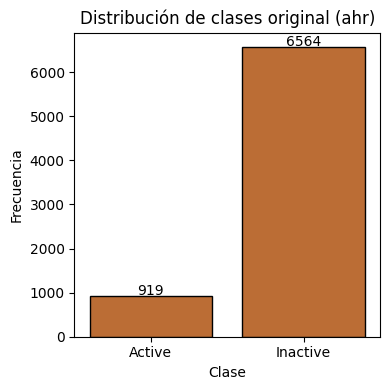

Histograma guardado en: /content/drive/MyDrive/QSAR/outputs/plots/ahr_initial_class_distribution.png


In [7]:
# Histograma de clases en la base de datos curada
activity_col = "Activity"
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=activity_col, data=df, edgecolor='black', color='chocolate', legend=False)
plt.title(f"Distribución de clases original ({target_name})")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, -1), textcoords='offset points')

plt.tight_layout()

# Guardar figura
out_path = f"{BASE_DIR}/outputs/plots/{target_name}_initial_class_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Histograma guardado en: {out_path}")


## **5. División estratificada**

In [8]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=random_state)

# Convertir X_train y X_test a DataFrame para mantener columnas e índices
X_train = pd.DataFrame(X_train, columns=X.columns, index=X.index[X_train.index])
X_test = pd.DataFrame(X_test, columns=X.columns, index=X.index[X_test.index])

## **6. Modelos base**

In [9]:
model_dict = {
    "rf": RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=n_jobs, random_state=random_state),
    "xgb": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", n_jobs=n_jobs, random_state=random_state, tree_method='auto'),
    "svm": SVC(kernel='rbf', probability=True, class_weight="balanced", random_state=random_state),
    "knn": KNeighborsClassifier(n_neighbors=5)
}

## **7. Hiperoptimización Optuna**

In [10]:
# === CLEAN TRANSFORMER ===
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, clip_value=1e6):
        self.clip_value = clip_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.nan_to_num(X, nan=0.0,
                          posinf=self.clip_value,
                          neginf=-self.clip_value)
        return np.clip(X, -self.clip_value, self.clip_value)

# === Función segura de StratifiedKFold ===
def safe_stratified_kfold(y, max_folds=5, shuffle=True, random_state=42):
    min_class_count = min(Counter(y).values())
    n_splits = min(max_folds, min_class_count)
    if n_splits < 2:
        raise ValueError(f"No se puede usar validación cruzada: solo hay {min_class_count} muestras en la clase menor.")
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# === BUILD PIPELINE ===
def build_pipeline(model, smote_k):
    return Pipeline([
        ("clean", CleanTransformer()),
        ("imputer", SimpleImputer(strategy="median")),
        ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

# === MAIN OPTIMIZATION FUNCTION ===
def optimize_model(X, y, model_name, hyperopt_method):

    # Codificación y cálculo de smote_k
    le = LabelEncoder()
    y = le.fit_transform(y)
    min_class = min(Counter(y).values())
    smote_k = max(1, min(min_class - 1, 5))

    # Selección del modelo base
    if model_name == "xgb":
        base_model = XGBClassifier(eval_metric="logloss", random_state=random_state,
                                  n_jobs=n_jobs, tree_method="hist")

    elif model_name == "rf":
        base_model = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

    elif model_name == "svm":
        base_model = SVC(probability=True, random_state=random_state, kernel='rbf')

    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_jobs=n_jobs)

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Pipeline y validación cruzada
    pipe = build_pipeline(base_model, smote_k)
    cv = safe_stratified_kfold(y, max_folds=5, random_state=random_state)

    # Solo Optuna para simplificar
    if hyperopt_method != "optuna":
        raise ValueError("Solo se soporta 'optuna' en esta versión simplificada")

    def objective(trial):
        # Definir espacios de búsqueda específicos para cada modelo
        if model_name == "xgb":
            params = {
                "model__max_depth": trial.suggest_int("model__max_depth", 3, 7),
                "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.3, log=True),
                "model__n_estimators": trial.suggest_int("model__n_estimators", 100, 500)
            }
        elif model_name == "rf":
            params = {
                "model__max_depth": trial.suggest_int("model__max_depth", 5, 30),
                "model__n_estimators": trial.suggest_int("model__n_estimators", 100, 500)
            }
        elif model_name == "svm":
            params = {
                "model__C": trial.suggest_float("model__C", 0.1, 10, log=True),
                "model__gamma": trial.suggest_float("model__gamma", 0.001, 1, log=True)
            }
        elif model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("model__n_neighbors", 3, 15),
                "model__weights": trial.suggest_categorical("model__weights", ['uniform', 'distance']),
                "model__p": trial.suggest_int("model__p", 1, 2)
            }

        trial_pipe = build_pipeline(clone(base_model), smote_k)
        trial_pipe.set_params(**params)

        scores = cross_val_score(
            trial_pipe,
            X,
            y,
            scoring="matthews_corrcoef",
            cv=cv,
            n_jobs=n_jobs
        )

        return scores.mean()

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=25)

    # Entrenar modelo final
    final_pipe = build_pipeline(base_model, smote_k)
    final_pipe.set_params(**study.best_params)
    final_pipe.fit(X, y)

    return final_pipe, le

## **8. Entrenamiento y stacking**

In [11]:
# Función de limpieza avanzada antes de evaluación
def clean_input(X, clip_value=1e4):
    # Reemplazar NaN, inf, -inf
    X = np.nan_to_num(X, nan=0.0, posinf=clip_value, neginf=-clip_value)
    # Clip valores extremos
    X = np.clip(X, -clip_value, clip_value)
    return X

X_train = clean_input(X_train)
X_test = clean_input(X_test)

# Confirmar que no haya valores fuera de rango
assert np.isfinite(X_test).all(), "X_test aún contiene valores no finitos"
assert np.isfinite(X_train).all(), "X_train aún contiene valores no finitos"

In [12]:
# Silenciar warnings innecesarios
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")
import xgboost as xgb
xgb.set_config(verbosity=0)  # Silenciar XGBoost


# Detección de tamaño de dataset
min_class = min(Counter(y_train).values())
n_splits = min(5, min_class)
do_cv = len(X_train) >= 20 and n_splits >= 2

print(f"Dataset info: Total train = {len(X_train)} | Min class = {min_class} | n_splits = {n_splits}")
if not do_cv:
    print("Dataset pequeño: se omite validación cruzada y se reduce k_neighbors en SMOTE.")

# Reajuste de SMOTE si se va a aplicar
if min_class <= 5:
    smote_k = max(1, min_class - 1)
else:
    smote_k = 5

# Reaplicar balanceo con k ajustado
pipeline = Pipeline([("smote", SMOTE(random_state=random_state, k_neighbors=smote_k))])
try:
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
    smote_success = True
except ValueError as e:
    print(f"SMOTE falló durante reaplicación: {e}")
    X_train, y_train = X_train, y_train
    smote_success = False

print(f"SMOTE reaplicado (pre-entrenamiento): {'Sí' if smote_success else 'No'} (k = {smote_k})")

# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # ["Active","Inactive"] → [0,1]
y_test_enc  = le.transform(y_test)

# Entrenamiento del modelo base

print(f"Entrenando modelo {model_name}{' con stacking' if use_stacking else ' sin stacking'}")

for _ in tqdm(range(1), desc="Entrenamiento del modelo"):
    if use_hyperopt:
        base_model, le = optimize_model(X_train, y_train_enc, model_name, hyperopt_method)
    else:
        base_model = model_dict[model_name]
        base_model.fit(X_train, y_train_enc)
        le = None

    if use_stacking:
        estimators = []
        for name in ['rf', 'xgb', 'svm', 'knn']:
            if name != model_name:
                estimators.append((name, model_dict[name]))

        clf = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(),
            n_jobs=n_jobs
        )
        clf.fit(X_train, y_train_enc)

    else:
        clf = base_model

# Guardado del modelo entrenado
model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_name}_{hyperopt_method}.pkl"
joblib.dump(clf, model_path)
print(f"Modelo guardado en: {model_path}")

Dataset info: Total train = 5612 | Min class = 689 | n_splits = 5
SMOTE reaplicado (pre-entrenamiento): Sí (k = 5)
Entrenando modelo rf sin stacking


Entrenamiento del modelo:   0%|          | 0/1 [00:00<?, ?it/s][I 2025-12-20 15:29:53,429] A new study created in memory with name: no-name-b5398b76-688d-405c-8603-afeac7852850
[I 2025-12-20 15:32:55,033] Trial 0 finished with value: 0.8976350356607231 and parameters: {'model__max_depth': 14, 'model__n_estimators': 481}. Best is trial 0 with value: 0.8976350356607231.
[I 2025-12-20 15:35:13,582] Trial 1 finished with value: 0.9041913691070306 and parameters: {'model__max_depth': 24, 'model__n_estimators': 340}. Best is trial 1 with value: 0.9041913691070306.
[I 2025-12-20 15:36:03,403] Trial 2 finished with value: 0.8570402698825392 and parameters: {'model__max_depth': 9, 'model__n_estimators': 162}. Best is trial 1 with value: 0.9041913691070306.
[I 2025-12-20 15:37:39,170] Trial 3 finished with value: 0.7935219513319355 and parameters: {'model__max_depth': 6, 'model__n_estimators': 447}. Best is trial 1 with value: 0.9041913691070306.
[I 2025-12-20 15:40:14,009] Trial 4 finished with

Modelo guardado en: /content/drive/MyDrive/QSAR/outputs/models/best_model_ahr_rf_optuna.pkl


## **9. Métricas y curvas**

1. Curva ROC (Receiver Operating Characteristic)

Ejes:
- X: FPR (False Positive Rate) → Falsos positivos / Total negativos reales
- Y: TPR (True Positive Rate) o Sensibilidad → Verdaderos positivos / Total positivos reales

Interpretación:
- La curva muestra la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos al variar el umbral de clasificación.
- El AUC (Área bajo la curva) mide la capacidad del modelo para separar las clases:
  - 🟢 AUC = 1.0: separación perfecta
  - ⚪ AUC = 0.5: azar (modelo inútil)
  - 🔵 AUC = 0.84 (en tu caso) = muy buen desempeño



In [13]:
# FUNCIÓN DE EVALUACIÓN DEL MODELO, MÉTRICAS Y CURVAS
def evaluate_model(clf, X_test, y_test, model_name, target_name, label_encoder):

    # === 1. Predicciones ===
    y_pred = clf.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # === 2. Métricas ===
    acc  = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # === 3. Guardar métricas en DataFrame ===
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Target": target_name,
        "Accuracy": acc,
        "Balanced_Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_score": f1,
        "MCC": mcc,
        "ROC_AUC": roc_auc
    }])

    metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_{model_name}.csv"
    metrics_df.to_csv(metrics_path, index=False)
    print(f"[OK] Métricas guardadas en: {metrics_path}")

    # Mostrar DataFrame
    display(metrics_df)

    # === 4. Gráficas ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    roc_disp = RocCurveDisplay.from_estimator(
        clf, X_test, y_test, ax=ax1,
        name=f"{model_name}", color="darkblue", linewidth=2
    )
    roc_disp.line_.set_linestyle("--")
    ax1.set_title(f"ROC Curve ({target_name} - {model_name})")
    ax1.grid(True, alpha=0.3)

    pr_disp = PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, ax=ax2,
        name=f"{model_name}", color="chocolate", linewidth=2
    )
    pr_disp.line_.set_linestyle("-")
    ax2.set_title(f"PR Curve ({target_name} - {model_name})")
    ax2.grid(True, alpha=0.3)

    plot_path = f"{BASE_DIR}/outputs/plots/roc_pr_{target_name}_{model_name}.png"
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"[OK] Gráficas guardadas en: {plot_path}")

    return {
        "metrics_df": metrics_df,
        "confusion_matrix": cm,
        "roc_auc": roc_auc,
        "y_pred": y_pred,
        "y_pred_labels": y_pred_labels,
        "y_proba": y_proba
    }


[OK] Métricas guardadas en: /content/drive/MyDrive/QSAR/outputs/reports/metrics_ahr_rf.csv


,Model,Target,Accuracy,Balanced_Accuracy,Precision,Recall,Specificity,F1_score,MCC,ROC_AUC
0,rf,ahr,0.899519,0.709065,0.9266,0.961609,0.456522,0.94378,0.480251,0.866167


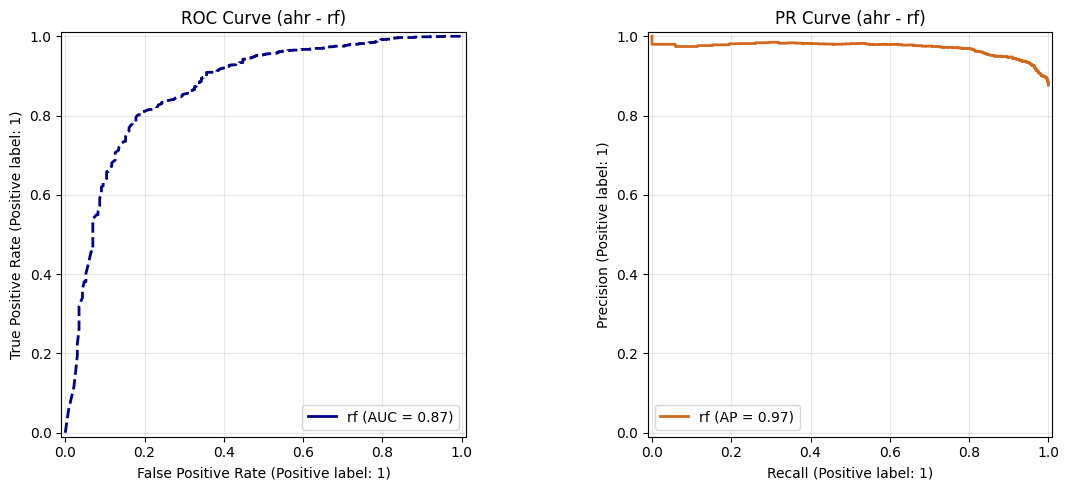

[OK] Gráficas guardadas en: /content/drive/MyDrive/QSAR/outputs/plots/roc_pr_ahr_rf.png
Evaluación completada.


In [14]:
# RESULTADOS DE LA EVALUACIÓN
results = evaluate_model(
    clf=clf,
    X_test=X_test,
    y_test=y_test_enc,
    model_name=model_name,
    target_name=target_name,
    label_encoder=le
)
print("Evaluación completada.")

## **10. Interpretabilidad SHAP**

Interpretabilidad SHAP para: ahr

--- Procesando: individual_model ---


PermutationExplainer explainer: 201it [06:53,  2.11s/it]
/tmp/ipython-input-2964617803.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)


✓ Explainer


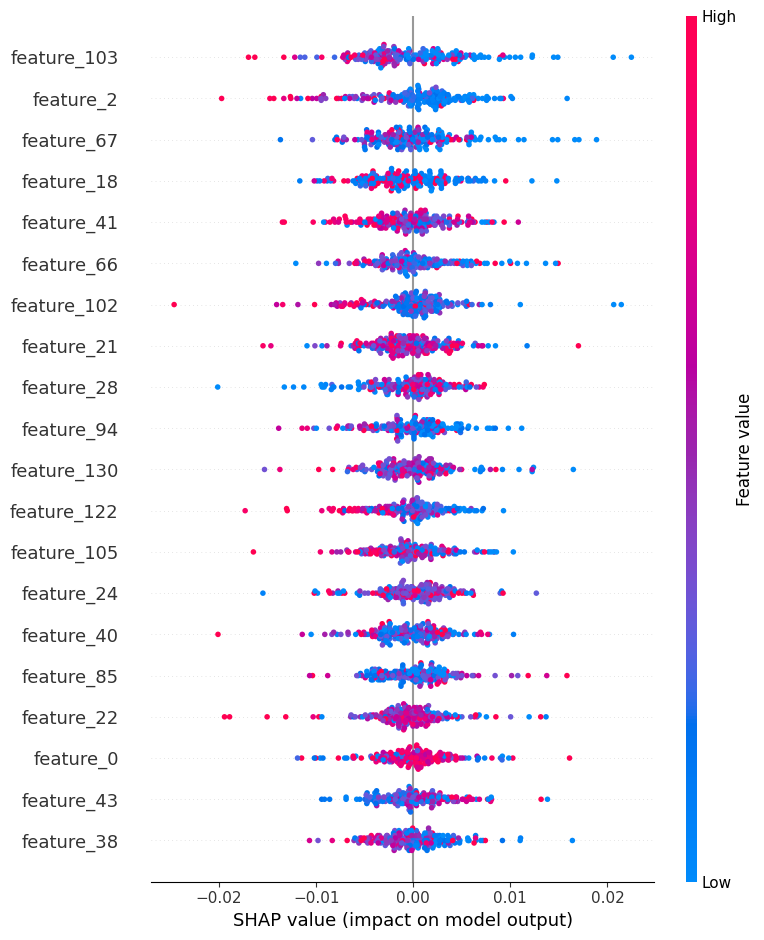

✓ Gráfico y CSV guardados para individual_model



In [32]:
import shap
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

print(f"Interpretabilidad SHAP para: {target_name}\n")

def process_model_shap(model, name, X_data, max_samples=200):
    """Procesa SHAP para un modelo individual"""
    try:
        print(f"--- Procesando: {model_name} ---")
        X_shap = X_data[:max_samples]
        X_shap_arr = X_shap.values if isinstance(X_shap, pd.DataFrame) else X_shap

        # Determinar tipo de explainer
        model_type = type(model).__name__.lower()
        tree_models = ['xgb', 'rf']
        is_tree_based = any(tree in model_type for tree in tree_models)

        # Crear explainer
        if is_tree_based:
            try:
                explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
                shap_values = explainer(X_shap_arr)
                print("✓ TreeExplainer")
            except:
                explainer = shap.Explainer(model.predict_proba, X_train)
                shap_values = explainer(X_shap_arr)
                print("✓ Explainer (fallback)")
        else:
            explainer = shap.Explainer(model.predict_proba, X_train)
            shap_values = explainer(X_shap_arr)
            print("✓ Explainer")

        # Procesar valores SHAP
        vals = np.array(shap_values.values)
        shap_vals = vals[..., 1] if vals.ndim == 3 else vals

        # Ajustar dimensiones si es necesario
        if shap_vals.shape[1] != len(feature_names):
            shap_vals = shap_vals[:, :len(feature_names)]

        # Generar gráfico y CSV
        plt.figure(figsize=(8, 12))
        shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f"{BASE_DIR}/outputs/plots/shap_{target_name}_{model_name}.png", dpi=300)
        plt.show()
        plt.close()

        # Exportar importancias
        importance_df = pd.DataFrame({
            "Descriptor": feature_names,
            "Mean_Abs_SHAP": np.abs(shap_vals).mean(axis=0)
        }).sort_values("Mean_Abs_SHAP", ascending=False)

        importance_df.to_csv(f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_{model_name}.csv", index=False)
        print(f"✓ Gráfico y CSV guardados para {name}\n")

    except Exception as e:
        print(f"✗ Error en {name}: {e}\n")

# Procesar todos los modelos del clasificador
def get_model_components(classifier):
    """Obtiene componentes individuales del clasificador"""
    if hasattr(classifier, 'named_estimators_') and classifier.named_estimators_:
        models = list(classifier.named_estimators_.items())
        if hasattr(classifier, 'final_estimator_'):
            models.append(('final_estimator', classifier.final_estimator_))
        return models
    return [('individual_model', classifier)]

# Ejecutar procesamiento
for model_name, model in get_model_components(clf):
    process_model_shap(model, model_name, X_test)

In [33]:
print(feature_names)

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70', 'feature_71', '

## **11. Y-Scrambling**

In [16]:
# Preprocesamiento


In [17]:
tqdm.pandas()

# Y-Scrambling
scores_scramble = []
for _ in tqdm(range(20), desc="Y-Scrambling"):
    y_scrambled = np.random.permutation(y_train)
    clf.fit(X_train, y_scrambled)
    y_pred_scramble = clf.predict(X_test)
    scores_scramble.append(matthews_corrcoef(y_test, y_pred_scramble))

yscramble_results_df = pd.DataFrame({'MCC': scores_scramble})
yscramble_results_df
# Guardar DataFrame con las 20 iteraciones
yscramble_results_df.to_csv(f"{BASE_DIR}/outputs/reports/yscramble_{target_name}_{model_name}.csv", index=False)

Y-Scrambling: 100%|██████████| 20/20 [11:56<00:00, 35.80s/it]


Media de MCC de Y-Scrambling: 0.0059
Desviación estándar de MCC de Y-Scrambling: 0.0258
MCC real del modelo: 0.4803


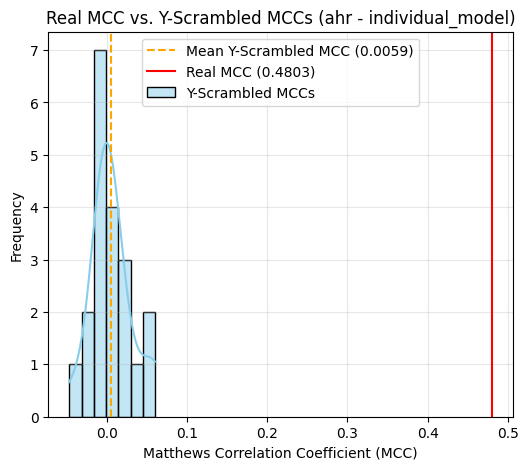

[OK] Gráfico de comparación de Y-Scrambling guardado en: /content/drive/MyDrive/QSAR/outputs/plots/yscramble_comparison_ahr_individual_model.png


In [18]:
# Resultados
mean_yscramble_mcc = yscramble_results_df['MCC'].mean()
std_yscramble_mcc = yscramble_results_df['MCC'].std()
real_mcc = results['metrics_df']['MCC'].iloc[0]

print(f"Media de MCC de Y-Scrambling: {mean_yscramble_mcc:.4f}")
print(f"Desviación estándar de MCC de Y-Scrambling: {std_yscramble_mcc:.4f}")
print(f"MCC real del modelo: {real_mcc:.4f}")

# Gráfica

plt.figure(figsize=(6, 5))
sns.histplot(yscramble_results_df['MCC'], kde=True, color='skyblue', label='Y-Scrambled MCCs')
plt.axvline(mean_yscramble_mcc, color='orange', linestyle='--', label=f'Mean Y-Scrambled MCC ({mean_yscramble_mcc:.4f})')
plt.axvline(real_mcc, color='red', linestyle='-', label=f'Real MCC ({real_mcc:.4f})')

plt.title(f'Real MCC vs. Y-Scrambled MCCs ({target_name} - {model_name})')
plt.xlabel('Matthews Correlation Coefficient (MCC)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plot_path = f"{BASE_DIR}/outputs/plots/yscramble_comparison_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"[OK] Gráfico de comparación de Y-Scrambling guardado en: {plot_path}")

## **12. Dominio de Aplicabilidad (AD)**

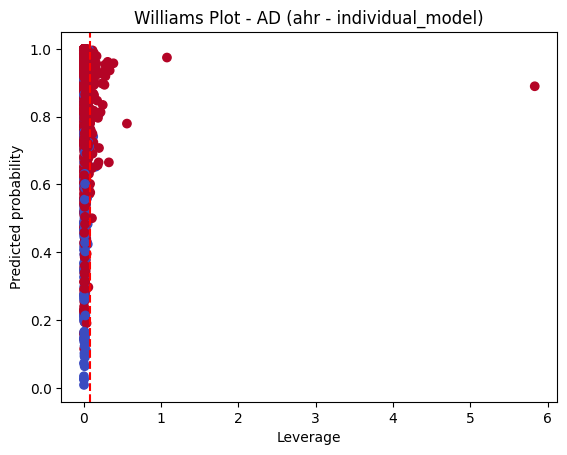

In [19]:
# Dominio de Aplicabilidad: Williams Plot (Leverage)
hat_matrix = X_test @ np.linalg.pinv(X_train.T @ X_train) @ X_test.T
leverage = np.diag(hat_matrix)
h_star = 3 * (X.shape[1] + 1) / X.shape[0]
plt.scatter(leverage, results['y_proba'], c=y_test_enc, cmap='coolwarm')
plt.axvline(h_star, color='red', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Predicted probability')
plt.title(f'Williams Plot - AD ({target_name} - {model_name})')
plt.show()
plt.savefig(f"{BASE_DIR}/outputs/plots/ad_williams_{target_name}_{model_name}.png")
plt.close()

## **13. Predicción externa**


--- Predicciones para SMILES válidos ---


,SMILES,Activity_Prediction,Probability,Leverage,AD_Flag,Molecule_Image
0,CC(=O)Nc1ccccc1C,1,0.630650,2.364719,Outside AD,
1,c1ccccc1O,1,0.626044,4.953967,Outside AD,

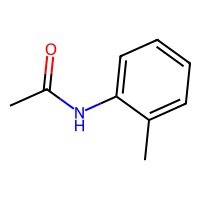
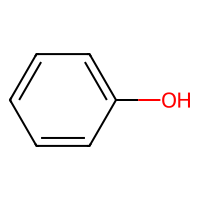


--- SMILES inválidos o con error de cálculo de descriptores ---


,Invalid_SMILES,Reason
0,invalid_smiles_string,Invalid SMILES or Descriptor Calculation Failed
1,1,Invalid SMILES or Descriptor Calculation Failed


In [20]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from IPython.display import HTML
import io
import base64

def mol_to_base64_image(mol, width=200, height=200):
    if mol is None:
        return None
    try:
        img = Draw.MolToImage(mol, size=(width, height))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print(f"Error generating image for molecule: {e}")
        return None

def predict_from_smiles(smiles_list):
    processed_data = []
    original_smiles = []
    molecule_images = []
    valid_mols = []
    invalid_smiles_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # Standardize molecule before descriptor calculation and image generation
            lfc = rdMolStandardize.LargestFragmentChooser()
            normalizer = rdMolStandardize.Normalizer()
            reionizer = rdMolStandardize.Reionizer()
            uncharger = rdMolStandardize.Uncharger()

            def standardize(m):
                try:
                    m = lfc.choose(m)
                    m = normalizer.normalize(m)
                    m = reionizer.reionize(m)
                    m = uncharger.uncharge(m)
                    return m
                except:
                    return None

            mol_std = standardize(mol)

            if mol_std is not None:
                smiles_std = Chem.MolToSmiles(mol_std)
                descriptors = calcular_descriptores(smiles_std)

                if all(d is not None for d in descriptors):
                    processed_data.append(descriptors)
                    original_smiles.append(s)
                    valid_mols.append(mol_std)
                    molecule_images.append(mol_to_base64_image(mol_std))
                else:
                    invalid_smiles_list.append(s)
            else:
                invalid_smiles_list.append(s)
        else:
            invalid_smiles_list.append(s)

    predictions_df = pd.DataFrame(columns=['SMILES', 'Activity_Prediction', 'Probability', 'Leverage', 'AD_Flag', 'Molecule_Image'])
    if processed_data:
        raw_X_ext = np.array(processed_data)

        # Apply preprocessing steps (clean, imputer, scaler) from the trained pipeline to raw_X_ext
        X_ext_preprocessed = clf.named_steps['clean'].transform(raw_X_ext)
        X_ext_preprocessed = clf.named_steps['imputer'].transform(X_ext_preprocessed)
        X_ext_preprocessed = clf.named_steps['scaler'].transform(X_ext_preprocessed)

        # Predictions
        y_proba = clf.predict_proba(X_ext_preprocessed)[:, 1]
        y_pred_encoded = clf.predict(X_ext_preprocessed)
        y_pred_labels = le.inverse_transform(y_pred_encoded)

        # Dominio de Aplicabilidad (Leverage)
        try:
            if not isinstance(X_train, pd.DataFrame):
                X_train_df = pd.DataFrame(X_train)
            else:
                X_train_df = X_train

            num_samples_train = X_train_df.shape[0]
            num_features_train = X_train_df.shape[1]
            h_star_recalculated = 3 * (num_features_train + 1) / num_samples_train

            hat = np.diag(X_ext_preprocessed @ np.linalg.pinv(X_train_df.T @ X_train_df) @ X_ext_preprocessed.T)
            ad_flag = ['Inside AD' if h < h_star_recalculated else 'Outside AD' for h in hat]
        except Exception as e:
            print(f"Error in AD calculation: {e}")
            hat = [np.nan] * len(original_smiles)
            ad_flag = ['Error in AD'] * len(original_smiles)

        # Create DataFrame with results
        predictions_df = pd.DataFrame({
            'SMILES': original_smiles,
            'Activity_Prediction': y_pred_labels,
            'Probability': y_proba,
            'Leverage': hat,
            'AD_Flag': ad_flag,
            'Molecule_Image': molecule_images
        })

    invalid_df = pd.DataFrame({
        'Invalid_SMILES': invalid_smiles_list,
        'Reason': ['Invalid SMILES or Descriptor Calculation Failed'] * len(invalid_smiles_list)
    }) if invalid_smiles_list else pd.DataFrame(columns=['Invalid_SMILES', 'Reason'])

    return predictions_df, invalid_df

# Helper function to display DataFrame with images
def display_df_with_images(df):
    if 'Molecule_Image' in df.columns:
        html_output = df.to_html(escape=False, formatters=dict(Molecule_Image=lambda img: f'<img src="data:image/png;base64,{img}">'))
        display(HTML(html_output))
    else:
        display(df)

# Predicción de ejemplo
predictions, invalid_smiles = predict_from_smiles(['CC(=O)Nc1ccccc1C', 'invalid_smiles_string', '1', 'c1ccccc1O'])

print("\n--- Predicciones para SMILES válidos ---")
display_df_with_images(predictions)

print("\n--- SMILES inválidos o con error de cálculo de descriptores ---")
display(invalid_smiles)
